In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.0.0
argon2-cffi                  21.1.0
astunparse                   1.6.3
attrs                        21.2.0
backcall                     0.2.0
bleach                       4.1.0
cachetools                   4.2.4
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.7
click                        8.0.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.0
defusedxml                   0.7.1
entrypoints                  0.3
flatbuffers                  2.0
gast                         0.4.0
google-auth                  2.3.3
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.41.1
h5py                         3.5.0
idna                         3.3
ipykernel                    6.5.0
ipython    

You should consider upgrading via the 'E:\lambda\labs\ds-test-2\venv2\Scripts\python.exe -m pip install --upgrade pip' command.


This notebook was executed on:
- Windows 10
- Ryzen 3900x
- 32 GB ram
- Nvidia 3080

# Research question:
is it possible using the sythetic dataset provided by generate.py and samples of user input provided by story_photo_transformer.py to generate coordinates with less than 8pix mean average error.

---

## Hypothesis
converting the input to grayscale and providing x and y axis value distribution information will lower MAE compared to the baseline model.

In [2]:
#shared experiment variables
global_batch_size = 96
global_epochs = 1000
global_learning_rate =.00015

In [3]:
# this allows tensorflow to find my local cuda installation, remove this or change it to match your environment

#%set_env CUDA_PATH=e:\cuda\bin
#%set_env CUDA_PATH_V11_2=e:\cuda\bin
#%set_env PATH=%PATH%;e:\cuda\bin;e:\cuda\extras;e:\cuda\include;e:\cuda\lib

import os
os.add_dll_directory(r'e:\cuda\bin')

import json

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import glob

# graphing function
def display_history(hist):
    # plot history

    loss_p = hist.history['loss']
    val_loss_p = hist.history['val_loss']

    plt.figure(figsize=(15,5))
    plt.plot(loss_p, label='MAE (training data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(val_loss_p, label='MAE (validation data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

class Gradient(tf.keras.layers.Layer):

    def __init__(self):
        super(Gradient, self).__init__()

    def call(self, inputs):
        return self.gradient(inputs)

    def gradient(self,a):
        rght = tf.concat((a[..., 1:], tf.expand_dims(a[..., -1], -1)), -1)
        left = tf.concat((tf.expand_dims(a[...,0], -1), a[..., :-1]), -1)
        ones = tf.ones_like(rght[..., 2:], tf.float32)
        one = tf.expand_dims(ones[...,0], -1)
        divi = tf.concat((one, ones*2, one), -1)
        return (rght-left) / divi

In [4]:

# this is the path to the synthetic data generated by generate.py, you may need to change this to match your system.
data_dir =r'..\..\..\models\synthetic_data\synthetic_data_for_pipeline_transform\data\*\*'
example_data_files = glob.glob(data_dir)[0:]
print(f'Example of data {example_data_files[0:3]}, {len(example_data_files)} records')

# load each of the X_input files using opencv and convert to BGR colorspace as required by opencv
X_train =[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in example_data_files if "X_input" in x ]
# load point data for each record
y_train =[ json.loads( open(y,'rb').read() )["y_label_points"] for y in example_data_files if ".json" in y ]

# convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape((X_train.shape[0],8))

# load real data
# this loads actual recorded user data that optimally we would like to predict with zero error.

path_real = r'..\..\..\data\transcribed_stories\*\*\phase0\*'
real_set=glob.glob(path_real)
# load and convert the data
X_real =np.array([ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in real_set if "X_input" in x ])
y_real =[ json.loads(open(y,'rb').read() )["y_label_points"] for y in real_set if ".json" in y ]
y_real = np.array(y_real).reshape((X_real.shape[0],8))

assert (X_real.shape[0]==y_real.shape[0])
print(f'Sythetic  data contains {X_train.shape[0]} records.')
print(f'Real data contains {X_real.shape[0]} records.')

Example of data ['..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.json', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.X_input.png', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.y_label.png'], 22170 records
Sythetic  data contains 7390 records.
Real data contains 3 records.


In [5]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale

grayscale=tf.reduce_mean(x,axis=3,name = "grayscale")
y_mean = tf.reduce_mean(grayscale,axis=2,name = "y_mean")
x_mean = tf.reduce_mean(grayscale,axis=1,name = "x_mean")
x = layers.Flatten()(grayscale)
x = tf.concat([y_mean,x_mean,x],1)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 256, 192)    0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.math.reduce_mean_1 (TFOpLam  (None, 256)         0           ['tf.math.reduce_mean[0][0]']    
 bda)                                                                                      

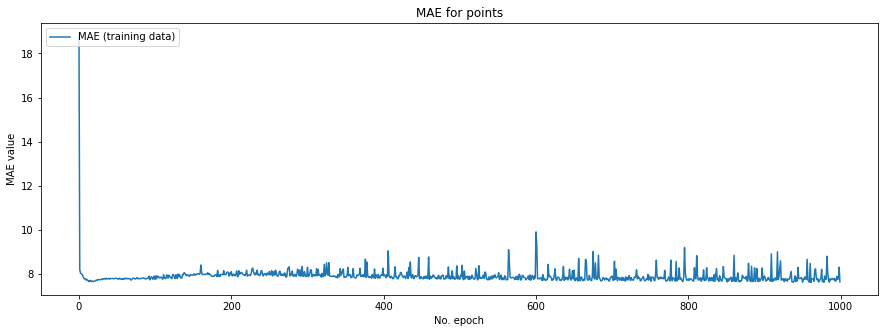

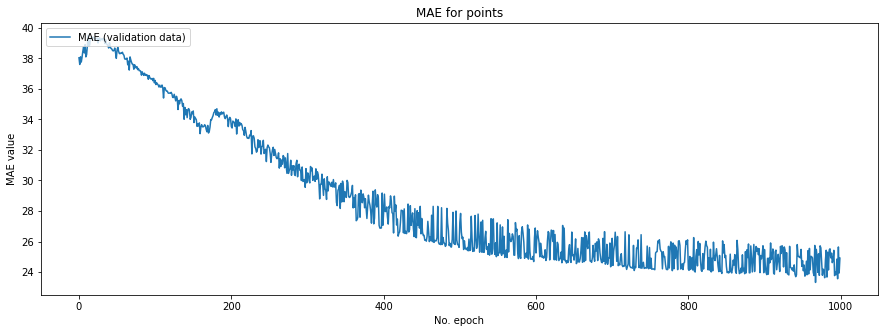

The minimum MAE achieved by the training was 7.628500461578369.
The minimum MAE achieved on the real data was 23.32073402404785.


In [6]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')

In [7]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale
grayscale=tf.reduce_mean(x,axis=3,name = "grayscale")

# distribution information
y_mean = tf.reduce_mean(grayscale,axis=2,name = "y_mean")
x_mean = tf.reduce_mean(grayscale,axis=1,name = "x_mean")

y_grad = Gradient()(y_mean)
x_grad = Gradient()(x_mean)

x = layers.Flatten()(grayscale)
x = tf.concat([y_mean,x_mean,y_grad,x_grad,x],1)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.reduce_mean_3 (TFOpLam  (None, 256, 192)    0           ['input_2[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.math.reduce_mean_4 (TFOpLam  (None, 256)         0           ['tf.math.reduce_mean_3[0][0]']  
 bda)                                                                                      

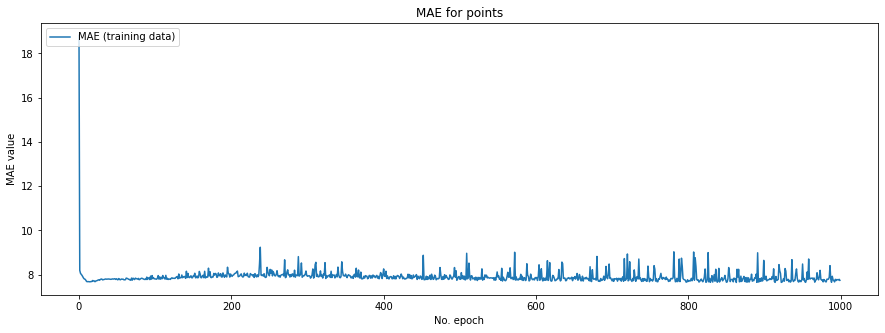

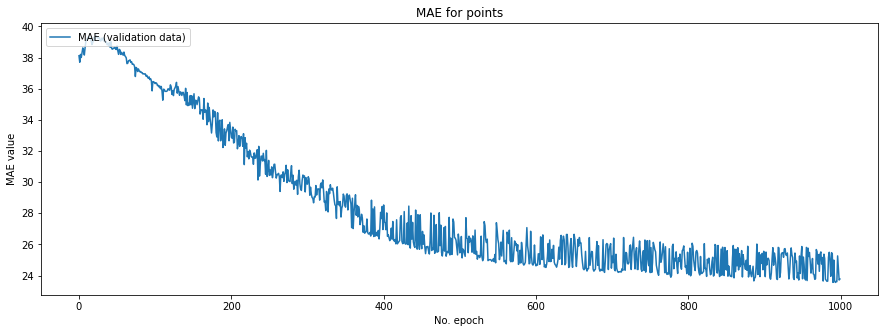

The minimum MAE achieved by the training was 7.646134853363037.
The minimum MAE achieved on the real data was 23.55926513671875.


In [8]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')


In [9]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale
grayscale=tf.reduce_mean(x,axis=3,name = "grayscale")

# distribution information
y_mean = tf.reduce_mean(grayscale,axis=2,name = "y_mean")
x_mean = tf.reduce_mean(grayscale,axis=1,name = "x_mean")

y_grad = Gradient()(y_mean)
x_grad = Gradient()(x_mean)

y_grad_2 = Gradient()(y_grad)
x_grad_2 = Gradient()(x_grad)

x = layers.Flatten()(grayscale)
x = tf.concat([y_mean,x_mean,y_grad,x_grad,y_grad_2,x_grad_2,x],1)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.reduce_mean_6 (TFOpLam  (None, 256, 192)    0           ['input_3[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.math.reduce_mean_7 (TFOpLam  (None, 256)         0           ['tf.math.reduce_mean_6[0][0]']  
 bda)                                                                                      

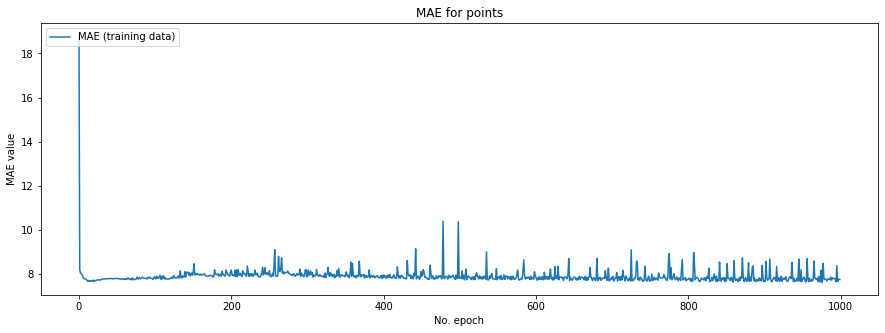

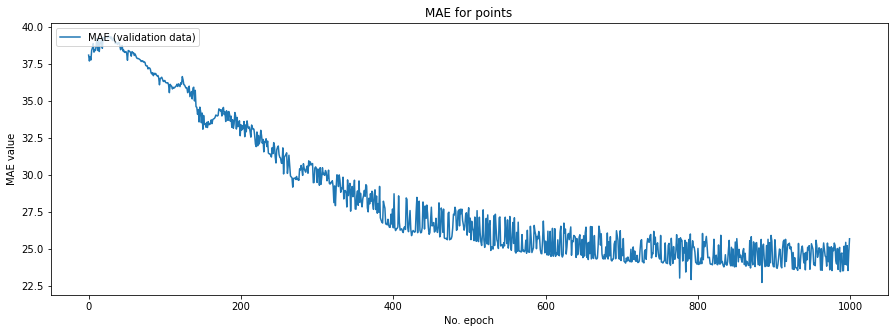

The minimum MAE achieved by the training was 7.629327297210693.
The minimum MAE achieved on the real data was 22.734418869018555.


In [10]:
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')


